## Install Libraries

In [31]:
from openseespy.opensees import *
import openseespy.postprocessing.Get_Rendering as opsplt
import openseespy.postprocessing.ops_vis as opsv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Unit Definition

In [32]:
# Units: kN, m, sec 

## Build Model - Reinforced Concrete Frame

In [33]:
# Clear memory of past model definitions
wipe()

# Create ModelBuilder (with two-dimensions and 3 DOF/node)
model('basic', '-ndm', 2, '-ndf', 3)

# Define the building nodes

# Set parameters for overall model geometry
width = 7.35
height = 3.00

# Create nodes
#    tag, X, Y
node(1, 0.0, 0.0)
node(2, width, 0.0)
node(3, 0.0, height)
node(4, width, height)

# Fix supports at base of columns
#   tag, DX, DY, RZ
fix(1, 1, 1, 1)
fix(2, 1, 1, 1)

# Define materials properties

# CONCRETE                   tag  f'c    ec0    f'cu   ecu
# Core concrete (confined)
uniaxialMaterial('Concrete01', 1, -28000.0, -0.004, -25000.0, -0.014)

# Cover concrete (unconfined)
uniaxialMaterial('Concrete01', 2, -25000.0, -0.002, 0.0, -0.006)

# STEEL
# Reinforcing steel
fy = 420000.0;  # Yield stress
E = 2.1*1e8;  # Young's modulus
#                         tag  fy E0    b
uniaxialMaterial('Steel01', 3, fy, E, 0.01)

# Define cross-section 

colWidth = 0.5
colDepth = 0.5

cover = 0.03
dia = 0.024 
As = np.pi*(dia/2)**2  # rebar area

y1 = colDepth / 2.0
z1 = colWidth / 2.0

section('Fiber', 1)

# Create the concrete core fibers
patch('rect', 1, 10, 1, cover - y1, cover - z1, y1 - cover, z1 - cover)

# Create the concrete cover fibers 
patch('rect', 2, 10, 1, -y1, z1 - cover, y1, z1)
patch('rect', 2, 10, 1, -y1, -z1, y1, cover - z1)
patch('rect', 2, 2, 1, -y1, cover - z1, cover - y1, z1 - cover)
patch('rect', 2, 2, 1, y1 - cover, cover - z1, y1, z1 - cover)

# Create the reinforcing fibers 
layer('straight', 3, 3, As, y1 - cover, z1 - cover, y1 - cover, cover - z1)
layer('straight', 3, 2, As, 0.0, z1 - cover, 0.0, cover - z1)
layer('straight', 3, 3, As, cover - y1, z1 - cover, cover - y1, cover - z1)

# Define the building elements

# Columns
geomTransf('PDelta', 1)

# Number of integration points along length of element
np = 5

# Lobatto integratoin
beamIntegration('Lobatto', 1, 1, np)

# Column elements
#               e            tag ndI ndJ transfTag integrationTag
eleType = 'forceBeamColumn'
element(eleType, 1, 1, 3, 1, 1)
element(eleType, 2, 2, 4, 1, 1)

# Beams
geomTransf('Linear', 2)

# Beam element
#                          tag, ndI, ndJ, A,     E,    Iz, transfTag
element('elasticBeamColumn', 3, 3, 4, 0.25, 30000000, 0.005, 2)

# Gravity loads

P = 720.0;  

# Create a Plain load pattern with a Linear TimeSeries
timeSeries('Linear', 1)
pattern('Plain', 1, 1)

# Create nodal loads at nodes 3 & 4
#    nd  FX,  FY, MZ
load(3, 0.0, -P, 0.0)
load(4, 0.0, -P, 0.0)

<IPython.core.display.Javascript object>


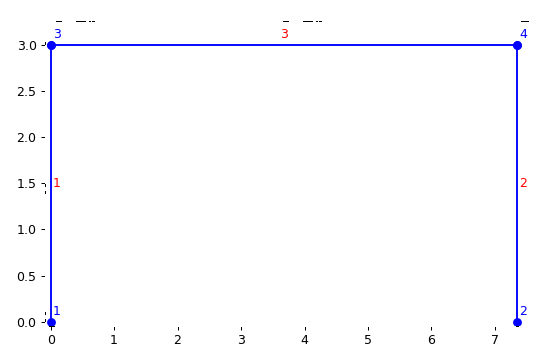

In [34]:
# Display Model

opsv.plot_model(1, 1)
plt.show(1)

## Gravity analysis

In [35]:
# Create the system of equation, a sparse solver with partial pivoting
system('BandGeneral')

# Create the constraint handler, the transformation method
constraints('Transformation')

# Create the DOF numberer, the reverse Cuthill-McKee algorithm
numberer('RCM')

# Create the convergence test, the norm of the residual with a tolerance of
# 1e-12 and a max number of iterations of 10
test('NormDispIncr', 1.0e-12, 10, 3)

# Create the solution algorithm, a Newton-Raphson algorithm
algorithm('Newton')

# Create the integration scheme, the LoadControl scheme using steps of 0.1
integrator('LoadControl', 0.1)

# Create the analysis object
analysis('Static')

# Perform the gravity load analysis, requires 10 steps to reach the load level
analyze(10)

# Set the gravity loads to be constant & reset the time in the domain
loadConst('-time', 0.0)

## Earthquake input

In [36]:
# Function to parse a ground motion record from the PEER strong motion database
# https://openseespydoc.readthedocs.io/en/stable/_downloads/44e412b61978e8c36a8b2550f96ab64b/ReadRecord.py

def ReadRecord (inFilename, outFilename):

    dt = 0.0
    npts = 0
    
    inFileID = open(inFilename, 'r')  
    outFileID = open(outFilename, 'w')
    flag = 0

    for line in inFileID:
        if line == '\n':
            # Blank line --> do nothing
            continue
        elif flag == 1:
            # Echo ground motion values to output file
            outFileID.write(line)
        else:
            # Search header lines for dt
            words = line.split()
            lengthLine = len(words)

            if lengthLine >= 4:

                if words[0] == 'NPTS=':
                    # old SMD format
                    for word in words:
                        if word != '':
                            # Read in the time step
                            if flag == 1:
                                dt = float(word)
                                break

                            if flag == 2:
                                npts = int(word.strip(','))
                                flag = 0

                            # Find the desired token and set the flag
                            if word == 'DT=' or word == 'dt':
                                flag = 1

                            if word == 'NPTS=':
                                flag = 2
                        
                    
                elif words[-1] == 'DT':
                    # new NGA format
                    count = 0
                    for word in words:
                        if word != '':
                            if count == 0:
                                npts = int(word)
                            elif count == 1:
                                dt = float(word)
                            elif word == 'DT':
                                flag = 1
                                break

                            count += 1                      
    inFileID.close()
    outFileID.close()

    return dt, npts

## Time-history analysis

<IPython.core.display.Javascript object>


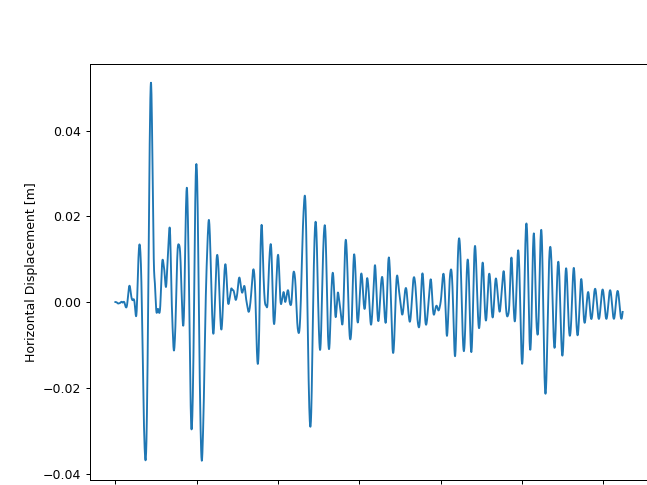

In [37]:
# Define nodal mass as axial load on columns
m = 100

mass(3, m, m, 0.0)
mass(4, m, m, 0.0)

# Set some parameters
record = 'elCentro'

# Permform the conversion from SMD record to OpenSees record
dt, nPts = ReadRecord(record+'.at2', record+'.dat')

# Set time series to be passed to uniform excitation
timeSeries('Path', 2, '-filePath', record+'.dat', '-dt', dt, '-factor', 9.81)

# Create UniformExcitation load pattern
#                         tag dir 
pattern('UniformExcitation',  2,   1,  '-accel', 2)

# set the rayleigh damping factors for nodes & elements
rayleigh(0.0, 0.0, 0.0, 0.000625)

# Delete the old analysis and all it's component objects
wipeAnalysis()

# Create the system of equation, a banded general storage scheme
system('BandGeneral')

# Create the constraint handler, a plain handler as homogeneous boundary
constraints('Plain')

# Create the convergence test, the norm of the residual with a tolerance of 
# 1e-12 and a max number of iterations of 10
test('NormDispIncr', 1.0e-12,  10 )

# Create the solution algorithm, a Newton-Raphson algorithm
algorithm('Newton')

# Create the DOF numberer, the reverse Cuthill-McKee algorithm
numberer('RCM')

# Create the integration scheme, the Newmark with alpha =0.5 and beta =.25
integrator('Newmark',  0.5,  0.25 )

# Create the analysis object
analysis('Transient')

# set some variables
tFinal = nPts*dt
tCurrent = getTime()
ok = 0

time = [tCurrent]
u3 = [0.0]

# Perform the transient analysis
while ok == 0 and tCurrent < tFinal:
    
    ok = analyze(1, .01)
    
    # if the analysis fails try initial tangent iteration
    if ok != 0:
        print("regular newton failed .. lets try an initail stiffness for this step")
        test('NormDispIncr', 1.0e-12,  100, 0)
        algorithm('ModifiedNewton', '-initial')
        ok =analyze( 1, .01)
        if ok == 0:
            print("that worked .. back to regular newton")
        test('NormDispIncr', 1.0e-12,  10 )
        algorithm('Newton')
    
    tCurrent = getTime()

    time.append(tCurrent)
    u3.append(nodeDisp(3,1))

plt.figure(2, figsize=(8, 6))
plt.plot(time, u3)
plt.ylabel('Horizontal Displacement [m]')
plt.xlabel('Time [Ss]')
plt.show(2)

<IPython.core.display.Javascript object>


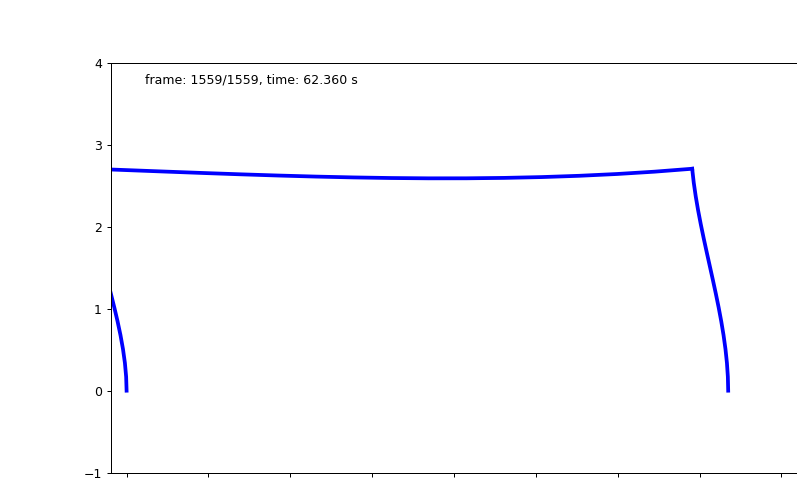

In [38]:
# Animation
import numpy as np

el_tags = getEleTags()
nels = len(el_tags)

Eds = np.zeros((nPts, nels, 6))
timeV = np.zeros(nPts)

# Analysis loop and collecting the data
for step in range(nPts):
    analyze(1, dt)
    timeV[step] = getTime()
    
    # Collect disp for element nodes
    for el_i, ele_tag in enumerate(el_tags):
        nd1, nd2 = eleNodes(ele_tag)
        Eds[step, el_i, :] = [nodeDisp(nd1)[0],
                              nodeDisp(nd1)[1],
                              nodeDisp(nd1)[2],
                              nodeDisp(nd2)[0],
                              nodeDisp(nd2)[1],
                              nodeDisp(nd2)[2]]

# Deformed shape
anim = opsv.anim_defo(Eds, timeV, 500, interpFlag=2, xlim=[-2, 10],
                      ylim=[-1, 4], fig_wi_he=(25, 15))
plt.show()

<IPython.core.display.Javascript object>


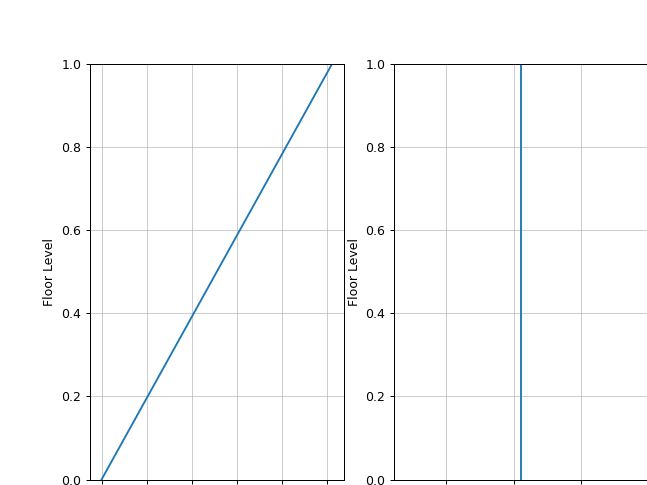

In [39]:
# Extrapolate Drift ratio

drift = max(u3)/height

fig, (bx, ax) = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))   

# Plot displacement 
bx.plot([0, max(u3)], [0, 1])
bx.set_xlabel('Displacement [m]')
bx.set_ylabel('Floor Level')
bx.set_ylim(0, 1)
bx.grid(True, linewidth=0.5)

# Plot drift ratio    
ax.step([drift, drift], [0, 1])
ax.set_ylim(0, 1)
ax.set_xlabel('Inter-story Drift Ratio')
ax.set_ylabel('Floor Level')
ax.grid(True, linewidth=0.5)

# Add legend
handles, labels = ax.get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
legend.set_title('El Centro 1940')

plt.show()